![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 5 - PyTorch</center>
### <center> CIFAR-10 Example </center>

# **<center>Exercise 2 - Solution by Silvian Grigoriu a36392 Elta**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/05_PyTorch/MainPyTorchCIFAR.ipynb)

In [1]:
#-- Wide screen:
from IPython.display import HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
#-- Auto reload reloads modules automatically before entering the execution of code typed at the IPython prompt
%load_ext autoreload
#-- Auto reload all the modules
%autoreload 2

In [3]:
if 'google.colab' in str(get_ipython()):
    #-- Provides information complementary similar to Tensorflow's model.summary()
    !pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#-- Imports:
import numpy             as np
import matplotlib.pyplot as plt

#-- torch:
import torch
import torch.nn            as nn      #-- package creating and training of the neural network
# import torch.nn.functional as F     #-- arithmetical operations, not the layers which have trainable parameters such as weights and bias terms
import torch.optim         as optim   #-- package implementing various optimization algorithms
import torchinfo                      #-- provides information complementary similar to Tensorflow's model.summary()

torch.backends.cudnn.benchmark = True   #-- enables benchmark mode in cudnn - input sizes for the network do not vary

In [5]:
#-- Read the pytorch and cuda version
print(f"The PyTorch and Cuda versions are : {torch.__version__}")

The PyTorch and Cuda versions are : 1.12.0+cu113


### Download CIFAR-10 dataset:

In [6]:
import torchvision
import torchvision.transforms as transforms

# DATA_PATH = '../../../FixelCourses/data/'
DATA_PATH = '../../data/'
oTrainSet = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True,  download=True, transform=transforms.ToTensor())   #-- numpy.ndarray to tensor
oTestSet  = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transforms.ToTensor())
lClasses  = oTrainSet.classes

(oTrainSet.data.shape, oTrainSet[0][0].shape, oTestSet.data.shape, oTestSet[0][0].shape)

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3),
 torch.Size([3, 32, 32]),
 (10000, 32, 32, 3),
 torch.Size([3, 32, 32]))

#### Plot some examples:

In [7]:
oTrainSet.data.shape, oTrainSet[0][0].shape   #--(<class 'numpy.ndarray'>,<class 'torch.Tensor'>)

((50000, 32, 32, 3), torch.Size([3, 32, 32]))

In [8]:
oTestSet.data.shape, oTestSet[0][0].shape     #--(<class 'numpy.ndarray'>,<class 'torch.Tensor'>)

((10000, 32, 32, 3), torch.Size([3, 32, 32]))

In [9]:
lClasses    #-- The categorical classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [10]:
list(zip(lClasses,range(len(lClasses))))    #-- The categorical classes with indexes

[('airplane', 0),
 ('automobile', 1),
 ('bird', 2),
 ('cat', 3),
 ('deer', 4),
 ('dog', 5),
 ('frog', 6),
 ('horse', 7),
 ('ship', 8),
 ('truck', 9)]

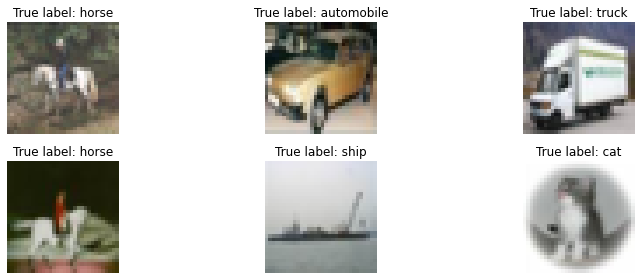

In [11]:
N, H, W, C = oTrainSet.data.shape   #-- N = number of samples
fig, _     = plt.subplots(2, 3, figsize=(12, 4))
for ax in fig.axes:
    idx   = np.random.randint(N)  #-- Choose random index
    mX, y = oTrainSet[idx]    #-- mX torch.Tensor, y = output label index
    #-- Returns a view of the original tensor input with its dimensions permuted.
    ax.imshow(mX.permute(1,2,0))    
    ax.set_title(f'True label: {lClasses[y]}')
    ax.axis     (False)
    
plt.tight_layout()
plt.show        ()

#### Compute mean pixel and its variance:

In [12]:
#-- Calculate the mean and std of the training set
vMean = oTrainSet.data.mean((0,1,2)) / 255    #-- Mean over each dimension and scaling
vStd  = oTrainSet.data.std ((0,1,2)) / 255

print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24703223 0.24348513 0.26158784]


#### Add normalization to the datasets (using `transform`):

In [13]:
#-- Composes several transforms together
oTransform = transforms.Compose([
    transforms.ToTensor (),   #-- Convert from numpy to torch tensor
    transforms.Normalize(vMean, vStd),
])

oTrainSet.transform = oTransform    #-- Save the transform
oTestSet .transform = oTransform

#### Create data loaders:

In [14]:
#-- The DataLoader retrieves our dataset’s features and labels one batch of samples at a time. 
#-- While training a model, we typically want to pass samples in “minibatches”, 
#-- reshuffle the data at every epoch to reduce model overfitting, 
#-- and use Python’s multiprocessing to speed up data retrieval.
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2, persistent_workers=True)

mX,       vY       = next(iter(oTrainDL))   #-- Iterate through the DataLoader. Next is the method to retrieve the batch
print(f"Features batch shape : {mX.shape}")
print(f"Labels batch shape : {vY.shape}")
mX.shape, vY.shape

Features batch shape : torch.Size([128, 3, 32, 32])
Labels batch shape : torch.Size([128])


(torch.Size([128, 3, 32, 32]), torch.Size([128]))

### Define the model (architecture):

In [15]:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(),    #-- does nothing
        nn.Flatten (),    #-- reshape (3, 32, 32) = (3072,)
        
        nn.Linear(3*32*32, 500), nn.ReLU(),
        nn.Linear(500,     250), nn.ReLU(),
        nn.Linear(250,     10 ),
    )
    return oModel

torchinfo.summary(GetModel(), mX.shape)   #-- mX.shape = input_size

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [128, 10]                 --
├─Identity: 1-1                          [128, 3, 32, 32]          --
├─Flatten: 1-2                           [128, 3072]               --
├─Linear: 1-3                            [128, 500]                1,536,500
├─ReLU: 1-4                              [128, 500]                --
├─Linear: 1-5                            [128, 250]                125,250
├─ReLU: 1-6                              [128, 250]                --
├─Linear: 1-7                            [128, 10]                 2,510
Total params: 1,664,260
Trainable params: 1,664,260
Non-trainable params: 0
Total mult-adds (M): 213.03
Input size (MB): 1.57
Forward/backward pass size (MB): 0.78
Params size (MB): 6.66
Estimated Total Size (MB): 9.01

#### A simple test:

In [16]:
oModel  = GetModel()
mX      = torch.randn(128, 3, 32, 32)
mLogits = oModel(mX)
mX.shape, mLogits.shape

(torch.Size([128, 3, 32, 32]), torch.Size([128, 10]))

#### Accuracy function
A `torch.tensor` stores the computational graph.  
Use `torch.Tensor.item()` to get a Python number from a tensor containing a single value.

In [17]:
#-- Returns the value of this tensor as a standard Python number. 
#-- This only works for tensors with one element.
x = torch.tensor(3.)
x.item()

3.0

In [18]:
#-- Classification accuracy:
def Accuracy(mLogits, vY):
    #-- mLogits.shape = (128, 10)
    #-- vY     .shape = (128,)

#   mLogits  = mLogits.detach()         #-- remove from the computational graph
    vHatY    = mLogits.argmax(dim=1)    #-- maximum index across the cotegories
    accuracy = (vHatY == vY).float().mean()
    return accuracy.item()
    
#-- Test the accuracy function:
Accuracy(mLogits, vY)

0.0703125

### PyTorch `Epoch`:

In [19]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU

    oModel.train(bTrain) #-- train or test
    
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE) #-- mX.shape = (128, 3, 32, 32)
        vY = vY.to(DEVICE) #-- vY.shape = (128,)
        
        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mZ   = oModel(mX)     #-- forward
            loss = Loss  (mZ, vY) #-- Softmax + CE
    
            #-- Backward:
            oOptim.zero_grad() #-- set gradients to zeros
            loss  .backward () #-- backward
            oOptim.step     () #-- update parameters
        else:
            with torch.no_grad(): #-- tensor with gradient is now detached from the current graph
                #-- Do not store computational graph:
                mZ   = oModel(mX)
                loss = Loss  (mZ, vY)

        with torch.no_grad():     #-- tensor with gradient is now detached from the current graph
            Nb           = mX.shape[0]
            count       += Nb
            epochLoss   += Nb * loss.item()
            epochMetric += Nb * Metric(mZ, vY)
            
        #-- Print if the phase is training or validation and the iteration number
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric

In [20]:
import time

def TrainClassficationModel(oModel, oTrainDL, oValDL, Loss, nEpochs, oOptim):

    vTrainLoss = np.full(nEpochs, np.nan)
    vTrainAcc  = np.full(nEpochs, np.nan)
    vValLoss   = np.full(nEpochs, np.nan)
    vValAcc    = np.full(nEpochs, np.nan)
    bestAcc    = 0

    for epoch in range(nEpochs):
        startTime           = time.time()
        trainLoss, trainAcc = Epoch(oModel, oTrainDL, Loss, Accuracy, oOptim, bTrain=True ) #-- train
        valLoss,   valAcc   = Epoch(oModel, oValDL,   Loss, Accuracy,         bTrain=False) #-- validation
        epochTime           = time.time() - startTime

        #-- Display:
        print('Epoch '              f'{epoch    :03d}:',   end='')
        print(' | Train loss: '     f'{trainLoss:6.3f}' ,  end='')
        print(' | Val loss: '       f'{valLoss  :6.3f}' ,  end='')
        print(' | Train Accuracy: ' f'{trainAcc :6.3f}',   end='')
        print(' | Val Accuracy: '   f'{valAcc   :6.3f}',   end='')
        print(' | Epoch time: '     f'{epochTime:6.3f} |', end='')

        vTrainLoss[epoch] = trainLoss
        vTrainAcc [epoch] = trainAcc
        vValLoss  [epoch] = valLoss
        vValAcc   [epoch] = valAcc

        #-- Save best model (early stopping):
        if bestAcc < valAcc:
            bestAcc = valAcc
            try:
                dCheckpoint = {'Model'     : oModel.state_dict(),
                               'Optimizer' : oOptim.state_dict()}
                torch.save(dCheckpoint, 'BestModel.pt')   #-- save object to disk file
            except:
                pass
            print(' <-- Checkpoint!')
        else:
            print('')

    #-- Load best model (early stopping):
    dCheckpoint = torch.load('BestModel.pt')
    oModel.load_state_dict(dCheckpoint['Model'])  #-- Loads a model’s parameter dictionary

    return vTrainLoss, vTrainAcc, vValLoss, vValAcc

#### Check whether GPU is available:

In [21]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
DEVICE

device(type='cuda', index=0)

#### Train the model:

In [22]:
nEpochs  = 20
Loss     = nn.CrossEntropyLoss()    #-- The Loss function used in the classification

oModel   = GetModel               ().to(DEVICE)   #-- Transfer the model to GPU
oOptim   = optim.AdamW            (oModel.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=1e-4)  #-- Implement AdamW optimization
lHistory = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim)    # Train and validate the model

Epoch 000: | Train loss:  1.702 | Val loss:  1.539 | Train Accuracy:  0.403 | Val Accuracy:  0.461 | Epoch time:  9.700 | <-- Checkpoint!
Epoch 001: | Train loss:  1.478 | Val loss:  1.450 | Train Accuracy:  0.484 | Val Accuracy:  0.494 | Epoch time: 12.521 | <-- Checkpoint!
Epoch 002: | Train loss:  1.377 | Val loss:  1.407 | Train Accuracy:  0.522 | Val Accuracy:  0.504 | Epoch time:  8.758 | <-- Checkpoint!
Epoch 003: | Train loss:  1.301 | Val loss:  1.378 | Train Accuracy:  0.549 | Val Accuracy:  0.517 | Epoch time:  8.239 | <-- Checkpoint!
Epoch 004: | Train loss:  1.238 | Val loss:  1.357 | Train Accuracy:  0.570 | Val Accuracy:  0.522 | Epoch time:  7.918 | <-- Checkpoint!
Epoch 005: | Train loss:  1.184 | Val loss:  1.331 | Train Accuracy:  0.592 | Val Accuracy:  0.532 | Epoch time:  8.214 | <-- Checkpoint!
Epoch 006: | Train loss:  1.130 | Val loss:  1.329 | Train Accuracy:  0.613 | Val Accuracy:  0.533 | Epoch time:  8.317 | <-- Checkpoint!
Epoch 007: | Train loss:  1.086 | 

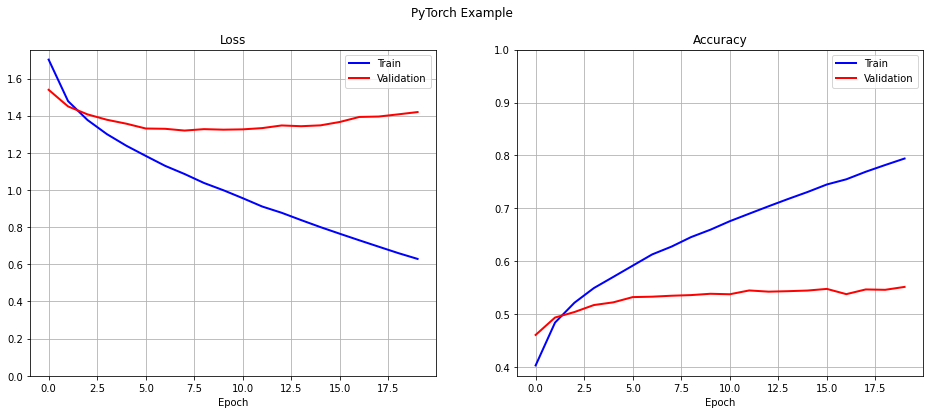

In [23]:
def PlotHistory(lHistory):

    vTrainLoss, vTrainAcc, vValLoss, vValAcc = lHistory
    
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1,2,1)
    plt.plot   (vTrainLoss, 'b', lw=2, label='Train'     )
    plt.plot   (vValLoss,   'r', lw=2, label='Validation')
    plt.title  ('Loss')
    plt.xlabel ('Epoch')
    plt.ylim   (bottom=0)
    plt.legend ()
    plt.grid   ()

    plt.subplot(1,2,2)
    plt.plot   (vTrainAcc, 'b', lw=2, label='Train'     )
    plt.plot   (vValAcc,   'r', lw=2, label='Validation')
    plt.title  ('Accuracy')
    plt.xlabel ('Epoch')
    plt.ylim   (top=1)
    plt.legend ()
    plt.grid   ()
    
PlotHistory (lHistory)
plt.suptitle('PyTorch Example')
plt.show    ()

### Exercise 1:
Improve the performance and get above 56% classification accuracy.
* Use dropout, `nn.Dropout(p)`<br>
Note that `p` is the probability of an element to be zeroed.

## Solution Exercise 1:

In [24]:
p = 0.2   #-- For display only - shall be as the parameter passed to function
def GetModel(p = 0.2):
    oModel = nn.Sequential(
        nn.Identity(),    #-- does nothing
        nn.Flatten (),    # reshape (3, 32, 32) = (3072,)
        
        nn.Linear(3*32*32, 500), nn.ReLU(), nn.Dropout(p),
        nn.Linear(500,     250), nn.ReLU(), nn.Dropout(p),
        nn.Linear(250,     10 ),
    )
    return oModel

torchinfo.summary(GetModel(), mX.shape)   #-- mX.shape = input_size

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [128, 10]                 --
├─Identity: 1-1                          [128, 3, 32, 32]          --
├─Flatten: 1-2                           [128, 3072]               --
├─Linear: 1-3                            [128, 500]                1,536,500
├─ReLU: 1-4                              [128, 500]                --
├─Dropout: 1-5                           [128, 500]                --
├─Linear: 1-6                            [128, 250]                125,250
├─ReLU: 1-7                              [128, 250]                --
├─Dropout: 1-8                           [128, 250]                --
├─Linear: 1-9                            [128, 10]                 2,510
Total params: 1,664,260
Trainable params: 1,664,260
Non-trainable params: 0
Total mult-adds (M): 213.03
Input size (MB): 1.57
Forward/backward pass size (MB): 0.78
Params size (MB): 6.66
Estimated Total Size (M

### Train the model

In [25]:
nEpochs  = 20
Loss     = nn.CrossEntropyLoss()    #-- The Loss function used in the training process

oModel   = GetModel               ().to(DEVICE)   #-- Transfer the model to GPU
oOptim   = optim.AdamW            (oModel.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=1e-4)  #-- Implement AdamW optimization
lHistory = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim)    # Train and validate the model

Epoch 000: | Train loss:  1.762 | Val loss:  1.567 | Train Accuracy:  0.381 | Val Accuracy:  0.456 | Epoch time:  8.114 | <-- Checkpoint!
Epoch 001: | Train loss:  1.566 | Val loss:  1.484 | Train Accuracy:  0.450 | Val Accuracy:  0.479 | Epoch time:  8.407 | <-- Checkpoint!
Epoch 002: | Train loss:  1.478 | Val loss:  1.430 | Train Accuracy:  0.483 | Val Accuracy:  0.502 | Epoch time:  8.367 | <-- Checkpoint!
Epoch 003: | Train loss:  1.418 | Val loss:  1.394 | Train Accuracy:  0.503 | Val Accuracy:  0.510 | Epoch time:  8.060 | <-- Checkpoint!
Epoch 004: | Train loss:  1.369 | Val loss:  1.369 | Train Accuracy:  0.519 | Val Accuracy:  0.519 | Epoch time:  8.210 | <-- Checkpoint!
Epoch 005: | Train loss:  1.327 | Val loss:  1.344 | Train Accuracy:  0.536 | Val Accuracy:  0.527 | Epoch time:  8.396 | <-- Checkpoint!
Epoch 006: | Train loss:  1.286 | Val loss:  1.336 | Train Accuracy:  0.552 | Val Accuracy:  0.530 | Epoch time:  8.824 | <-- Checkpoint!
Epoch 007: | Train loss:  1.250 | 

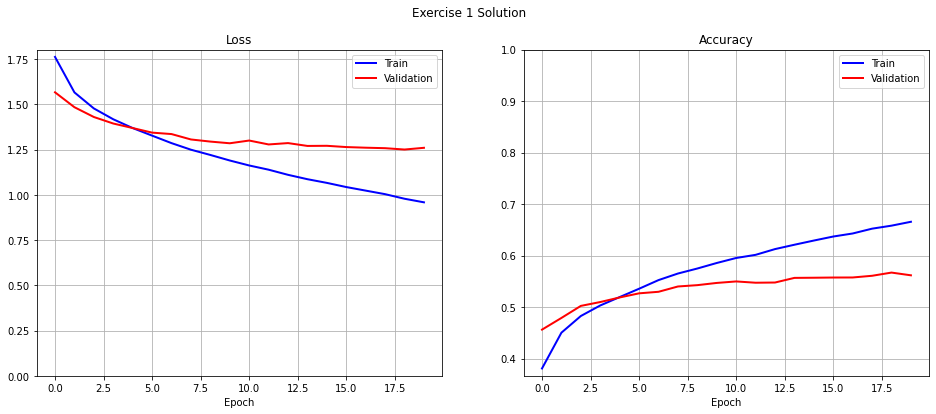

In [26]:
PlotHistory (lHistory)
plt.suptitle('Exercise 1 Solution')
plt.show    ()

In [27]:
#-- It is posible to test a finite set of values for dropout probability P and to choose
#-- the optimum value which achieves the highest value for the validation accuracy.
#-- Here we used only one value for P = 0.2
vTrainLoss, vTrainAcc, vValLoss, vValAcc = lHistory
print(f"The maximum validation accuracy achieved is {max(vValAcc)} for dropout probability P = {p}")

The maximum validation accuracy achieved is 0.567 for dropout probability P = 0.2


### Exercise 2:
* Use the California housing dataset `fetch_california_housing`.
* Use MSE loss: `nn.MSELoss()`
* Replace the classification accuracy with $R^2$ score.
* Try to get the best MSE\R2 score you can.

**Tips**:
* You should test different models (layers\activations) and hyper-parameters.
* Try different optimizers and regularizations.
* $R_2 > 0.8$ (on the validation set) is quite good.

In [52]:
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)
mX, vY  = fetch_california_housing(return_X_y=True)
#-- vY = Prediction of currenthousing prices

#-- Perform normalization of the data
#-- With this type of scaling all the data is seen - best practice
#-- use standardscaler()
mX     -= mX.mean(0)
mX     /= mX.std (0)

mX.shape, vY.shape

((20640, 8), (20640,))

In [53]:
#-- Display the first records of the data
california_housing.frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [54]:
#-- Display the information of the data
california_housing.frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


### **Conclusions:**  
1. The dataset contains 20640 samples and 8 features.
2. All features are numerical features encoded as floating number.
3. There are no missing values.

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics      import r2_score

#-- Build classical Linear Regression and calculate the R2_score for reference
#-- with PyTorch processing model that will be further built
oReg = LinearRegression().fit(mX,vY)
vHatY = oReg.predict(mX)
print(f"MSE classical Linear Regression = {np.linalg.norm(vHatY - vY)**2 / len(vY)}")
print(f"R² classical Linear Regression  = {r2_score(vY, vHatY)}")


MSE classical Linear Regression = 0.5243209861846072
R² classical Linear Regression  = 0.606232685199805


In [56]:
from torch.utils.data import TensorDataset

nTrain              = 15000
nTest               = 5640
#-- Create a dataset object that contains tensors for input features and labels
oDataset            = TensorDataset(torch.tensor(mX, dtype=torch.float32), torch.tensor(vY, dtype=torch.float32))
#-- Split the dataset into training and validation sets
oTrainSet, oValSet  = torch.utils.data.random_split(oDataset, [nTrain, nTest])
#-- Should be as required nTrain = 15000, nTest = 5640 
len(oTrainSet), len(oValSet)

(15000, 5640)

#### $R^2$ function
`tensor.detach()` creates a tensor that shares storage with `tensor` that does not require grad.

In [57]:
from sklearn.metrics import r2_score

def R2Score(vHatY, vY):
    #-- Return a copy in the CPU and reshape to 1-D 
    vY    = vY.detach().cpu().view(-1)      #-- does not required gradient
    vHatY = vHatY.detach().cpu().view(-1)   #-- does not required gradient
    return r2_score(vY, vHatY)

In [58]:
import time

def TrainRegressionModel(oModel, oTrainData, oValData, Loss, nEpochs, oOptim):

    vTrainLoss = np.full(nEpochs, np.nan)
    vTrainR2   = np.full(nEpochs, np.nan)
    vValLoss   = np.full(nEpochs, np.nan)
    vValR2     = np.full(nEpochs, np.nan)
    bestR2     = 0

    for epoch in range(nEpochs):
        startTime = time.time()
        #-- The code is like before with Accuracy which was replaced by R2Score
        trainLoss, trainR2 = Epoch(oModel, oTrainData, Loss, R2Score, oOptim, bTrain=True ) #-- train
        valLoss,   valR2   = Epoch(oModel, oValData,   Loss, R2Score,         bTrain=False) #-- validate
        epochTime = time.time() - startTime

        #-- Display:
        print('Epoch '          f'{epoch     :03d}:',   end='')
        print(' | Train loss: ' f'{trainLoss :6.3f}' ,  end='')
        print(' | Val loss: '   f'{valLoss   :6.3f}' ,  end='')
        print(' | Train R2: '   f'{trainR2  :+6.3f}',   end='')
        print(' | Val R2: '     f'{valR2    :+6.3f}',   end='')
        print(' | Epoch time: ' f'{epochTime :3.3f} |', end='')

        vTrainLoss[epoch] = trainLoss
        vTrainR2  [epoch] = trainR2
        vValLoss  [epoch] = valLoss
        vValR2    [epoch] = valR2

        #-- Save best model (early stopping):
        if bestR2 < valR2:   #-- Update the best R2 value if required and save the corresponding model
            bestR2 = valR2
            try:
                dCheckpoint = {'Model'     : oModel.state_dict(),
                               'Optimizer' : oOptim.state_dict()}
                torch.save(dCheckpoint, 'BestModel.pt')
            except:
                pass
            print(' <-- Checkpoint!')
        else:
            print('')

    #-- Load best model (early stopping):
    dCheckpoint = torch.load('BestModel.pt')
    oModel.load_state_dict(dCheckpoint['Model'])

    return vTrainLoss, vTrainR2, vValLoss, vValR2

### Create DataLoaders

In [59]:
#-- The DataLoader retrieves our dataset’s features and labels one batch of samples at a time. 
#-- While training a model, we typically want to pass samples in “minibatches”, 
#-- reshuffle the data at every epoch to reduce model overfitting, 
#-- and use Python’s multiprocessing to speed up data retrieval.
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2, persistent_workers=True)
oValDL    = torch.utils.data.DataLoader(oValSet,   shuffle=False, batch_size=2*batchSize, num_workers=2, persistent_workers=True)

mX,       vY       = next(iter(oTrainDL))   #-- Iterate through the DataLoader
print(f"Features batch shape : {mX.shape}")
print(f"Labels batch shape : {vY.shape}")
mX.shape, vY.shape

Features batch shape : torch.Size([128, 8])
Labels batch shape : torch.Size([128])


(torch.Size([128, 8]), torch.Size([128]))

In [60]:
import torch.nn            as nn
import torch.optim         as optim
import torchinfo

#-- Model:
def GetModel(p = 0.08):
    oModel = nn.Sequential(
        nn.Identity(),  #-- does nothing for display input only
        nn.Linear (8,   900), nn.LeakyReLU(0.01), nn.Dropout(p),
        nn.Linear (900, 700), nn.LeakyReLU(0.01), nn.Dropout(p),
        nn.Linear (700, 500), nn.LeakyReLU(0.01), nn.Dropout(p),
        nn.Linear (500, 300), nn.LeakyReLU(0.01), nn.Dropout(p),
        nn.Linear (300, 100), nn.LeakyReLU(0.01), nn.Dropout(p),
        nn.Linear (100, 1),
        nn.Flatten(start_dim=0)
    )

    def InitWeights(oLayer):
        if isinstance(oLayer, nn.Linear):   #-- do only for LinearLayer
            nn.init.kaiming_normal_(oLayer.weight.data, mode='fan_out', nonlinearity='leaky_relu')
            #-- nn.init.xavier_normal_(oLayer.weight.data)

    #-- Applies InitWeights recursively to every layer in the model oModel based 
    #-- on the condition that exists in InitWeights
    oModel.apply(InitWeights)
   
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchinfo.summary(GetModel(), mX.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [128]                     --
├─Identity: 1-1                          [128, 8]                  --
├─Linear: 1-2                            [128, 900]                8,100
├─LeakyReLU: 1-3                         [128, 900]                --
├─Dropout: 1-4                           [128, 900]                --
├─Linear: 1-5                            [128, 700]                630,700
├─LeakyReLU: 1-6                         [128, 700]                --
├─Dropout: 1-7                           [128, 700]                --
├─Linear: 1-8                            [128, 500]                350,500
├─LeakyReLU: 1-9                         [128, 500]                --
├─Dropout: 1-10                          [128, 500]                --
├─Linear: 1-11                           [128, 300]                150,300
├─LeakyReLU: 1-12                        [128, 300]                

### Check whether GPU is available:

In [61]:
#-- Check if GPU exist 
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
DEVICE

device(type='cuda', index=0)

In [62]:
nEpochs = 150
Loss    = nn.MSELoss()            # The Loss function used

oModel  = GetModel().to(DEVICE)   #-- Transfer the model to GPU
oOptim  = optim.AdamW             (oModel.parameters(), lr=5e-4, betas=(0.9, 0.99), weight_decay=2e-4)  #-- Implement AdamW optimization

lHistory = TrainRegressionModel(oModel, oTrainDL, oValDL, Loss, nEpochs, oOptim)  #-- train and validate the model

Epoch 000: | Train loss:  7.603 | Val loss:  0.776 | Train R2: -5.101 | Val R2: +0.406 | Epoch time: 0.816 | <-- Checkpoint!
Epoch 001: | Train loss:  6.526 | Val loss:  0.581 | Train R2: -4.530 | Val R2: +0.559 | Epoch time: 0.790 | <-- Checkpoint!
Epoch 002: | Train loss:  5.771 | Val loss:  1.034 | Train R2: -2.980 | Val R2: +0.195 | Epoch time: 0.764 |
Epoch 003: | Train loss:  1.598 | Val loss:  0.550 | Train R2: -0.207 | Val R2: +0.579 | Epoch time: 0.791 | <-- Checkpoint!
Epoch 004: | Train loss:  2.682 | Val loss:  0.455 | Train R2: -0.964 | Val R2: +0.653 | Epoch time: 0.776 | <-- Checkpoint!
Epoch 005: | Train loss:  3.046 | Val loss:  0.463 | Train R2: -2.022 | Val R2: +0.648 | Epoch time: 0.757 |
Epoch 006: | Train loss:  2.132 | Val loss:  0.403 | Train R2: -0.445 | Val R2: +0.693 | Epoch time: 0.735 | <-- Checkpoint!
Epoch 007: | Train loss:  1.089 | Val loss:  0.408 | Train R2: +0.158 | Val R2: +0.689 | Epoch time: 0.749 |
Epoch 008: | Train loss:  1.168 | Val loss:  0.3

In [63]:
#-- It is posible to test a finite set of hyperparameters' values and to choose
#-- the optimum value which achieves the highest value for the validation R2_score.

vTrainLoss, vTrainR2, vValLoss, vValR2 = lHistory
print(f"The maximum validation R2_score achieved is {max(vValR2)}")

The maximum validation R2_score achieved is 0.8150764330030581


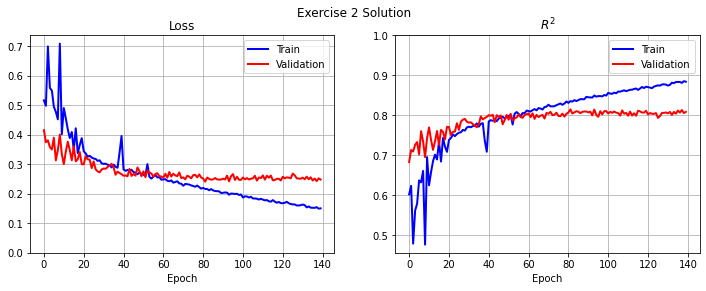

In [64]:
def PlotHistory(lHistory):

    vTrainLoss, vTrainR2, vValLoss, vValR2 = lHistory
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1,2,1)
    plt.plot   (vTrainLoss[10:], 'b', lw=2, label='Train'     )
    plt.plot   (vValLoss[10:],   'r', lw=2, label='Validation')
    plt.title  ('Loss')
    plt.xlabel ('Epoch')
    plt.ylim   (bottom=0)
    plt.legend ()
    plt.grid   ()

    plt.subplot(1,2,2)
    plt.plot   (vTrainR2[10:], 'b', lw=2, label='Train'     )
    plt.plot   (vValR2[10:],   'r', lw=2, label='Validation')
    plt.title  ('$R^2$')
    plt.xlabel ('Epoch')
    plt.ylim   (top=1)
    plt.legend ()
    plt.grid   ()
    
PlotHistory (lHistory)
plt.suptitle('Exercise 2 Solution')
plt.show    ()

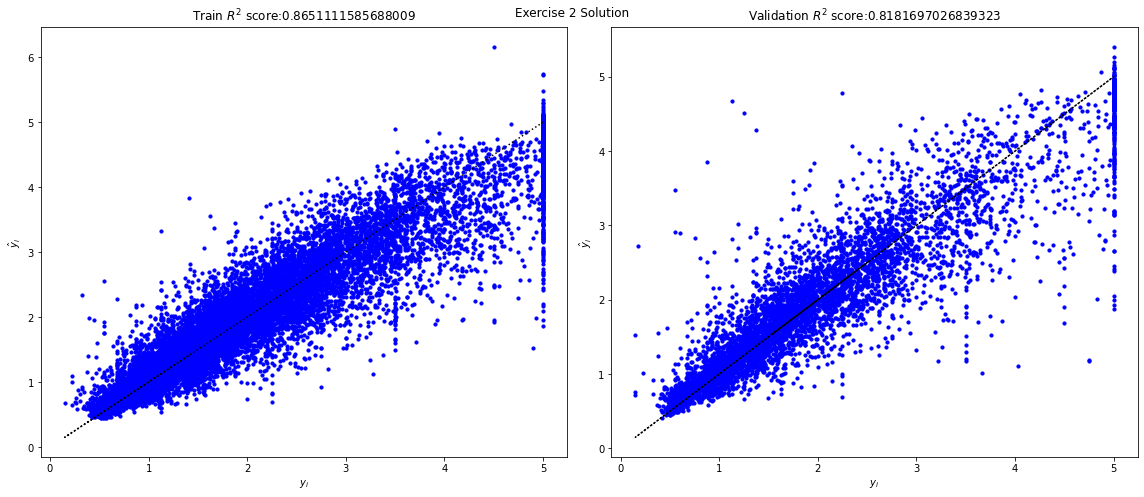

In [65]:
from torch.utils.data import DataLoader
from sklearn.metrics  import r2_score

#-- Entire dataset in one batch:
mTrainX, vTrainY = next(iter(DataLoader(oTrainSet, shuffle=False, batch_size=nTrain)))
mValX,   vValY   = next(iter(DataLoader(oValSet,   shuffle=False, batch_size=nTest )))

#-- Apply model to data:
with torch.no_grad():
    vHatTrainY = oModel(mTrainX.to(DEVICE)).detach().cpu()
    vHatValY   = oModel(mValX  .to(DEVICE)).detach().cpu()

_, ax = plt.subplots(1, 2, figsize=(16, 7))

ax[0].scatter   (vTrainY, vHatTrainY, s=10, c='b', edgecolor=None)
ax[1].scatter   (vValY,   vHatValY,   s=10, c='b', edgecolor=None)
ax[0].plot      (vTrainY, vTrainY, ':k')
ax[1].plot      (vValY,   vValY,   ':k')
ax[0].set_title ('Train $R^2$ score:'      f'{r2_score(vTrainY, vHatTrainY)}')
ax[1].set_title ('Validation $R^2$ score:' f'{r2_score(vValY,   vHatValY)}')
ax[0].set_xlabel('$y_i$')
ax[1].set_xlabel('$y_i$')
ax[0].set_ylabel('$\hat{y}_i$')
ax[1].set_ylabel('$\hat{y}_i$')

plt.tight_layout()
plt.suptitle('Exercise 2 Solution')
plt.show        ()

### New Models with different regularizations and optimizations  
Use activation layer ReLU() instead of LeakyRelu() and Xavier weights initialization instead of Kaiming weights initialization.  
Than use the same model but with SGD optimization instead of AdamW optimization

### First Model option

In [66]:
import torch.nn            as nn
import torch.optim         as optim
import torchinfo

#-- Model:
def GetModel2(p = 0.08):
    oModel = nn.Sequential(
        nn.Identity(),  #-- does nothing for display input only
        nn.Linear (8,   900), nn.ReLU(), nn.Dropout(p),
        nn.Linear (900, 700), nn.ReLU(), nn.Dropout(p),
        nn.Linear (700, 500), nn.ReLU(), nn.Dropout(p),
        nn.Linear (500, 300), nn.ReLU(), nn.Dropout(p),
        nn.Linear (300, 100), nn.ReLU(), nn.Dropout(p),
        nn.Linear (100, 1),
        nn.Flatten(start_dim=0)
    )

    def InitWeights(oLayer):
        if isinstance(oLayer, nn.Linear):   #-- do only for LinearLayer
            #-- nn.init.kaiming_normal_(oLayer.weight.data, mode='fan_out', nonlinearity='leaky_relu')
            nn.init.xavier_normal_(oLayer.weight.data)

    #-- Applies InitWeights recursively to every layer in the model oModel based 
    #-- on the condition that exists in InitWeights
    oModel.apply(InitWeights)
   
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchinfo.summary(GetModel(), mX.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [128]                     --
├─Identity: 1-1                          [128, 8]                  --
├─Linear: 1-2                            [128, 900]                8,100
├─LeakyReLU: 1-3                         [128, 900]                --
├─Dropout: 1-4                           [128, 900]                --
├─Linear: 1-5                            [128, 700]                630,700
├─LeakyReLU: 1-6                         [128, 700]                --
├─Dropout: 1-7                           [128, 700]                --
├─Linear: 1-8                            [128, 500]                350,500
├─LeakyReLU: 1-9                         [128, 500]                --
├─Dropout: 1-10                          [128, 500]                --
├─Linear: 1-11                           [128, 300]                150,300
├─LeakyReLU: 1-12                        [128, 300]                

In [67]:
nEpochs = 150
Loss    = nn.MSELoss()    #-- Loss methos

oModel  = GetModel2().to(DEVICE)  #-- Transfer the new model to GPU
oOptim  = optim.AdamW            (oModel.parameters(), lr=5e-4, betas=(0.9, 0.99), weight_decay=2e-4)  #-- Implement AdamW optimization

lHistory = TrainRegressionModel(oModel, oTrainDL, oValDL, Loss, nEpochs, oOptim)  #-- train and validate the model

Epoch 000: | Train loss:  0.776 | Val loss:  0.400 | Train R2: +0.410 | Val R2: +0.695 | Epoch time: 0.754 | <-- Checkpoint!
Epoch 001: | Train loss:  0.452 | Val loss:  0.402 | Train R2: +0.656 | Val R2: +0.691 | Epoch time: 0.757 |
Epoch 002: | Train loss:  0.421 | Val loss:  0.342 | Train R2: +0.681 | Val R2: +0.738 | Epoch time: 0.817 | <-- Checkpoint!
Epoch 003: | Train loss:  0.412 | Val loss:  0.357 | Train R2: +0.685 | Val R2: +0.725 | Epoch time: 0.876 |
Epoch 004: | Train loss:  0.373 | Val loss:  0.424 | Train R2: +0.715 | Val R2: +0.677 | Epoch time: 0.963 |
Epoch 005: | Train loss:  0.373 | Val loss:  0.327 | Train R2: +0.714 | Val R2: +0.751 | Epoch time: 0.845 | <-- Checkpoint!
Epoch 006: | Train loss:  0.359 | Val loss:  0.338 | Train R2: +0.726 | Val R2: +0.742 | Epoch time: 0.773 |
Epoch 007: | Train loss:  0.355 | Val loss:  0.300 | Train R2: +0.729 | Val R2: +0.770 | Epoch time: 0.758 | <-- Checkpoint!
Epoch 008: | Train loss:  0.347 | Val loss:  0.294 | Train R2: +

In [68]:
#-- It is posible to test a finite set of hyperparameters' values and to choose
#-- the optimum value which achieves the highest value for the validation R2_score.

vTrainLoss, vTrainR2, vValLoss, vValR2 = lHistory
print(f"The maximum validation R2_score achieved is {max(vValR2)}")

The maximum validation R2_score achieved is 0.8122617070054853


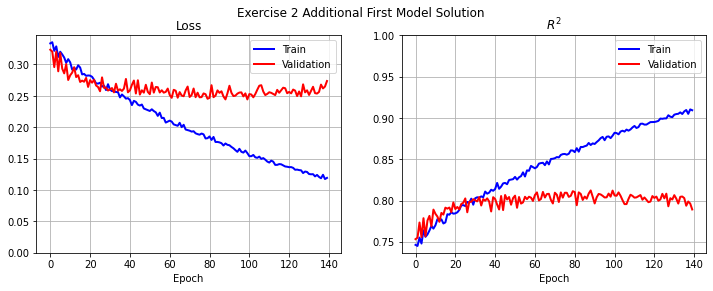

In [69]:
PlotHistory (lHistory)
plt.suptitle('Exercise 2 Additional First Model Solution')
plt.show    ()

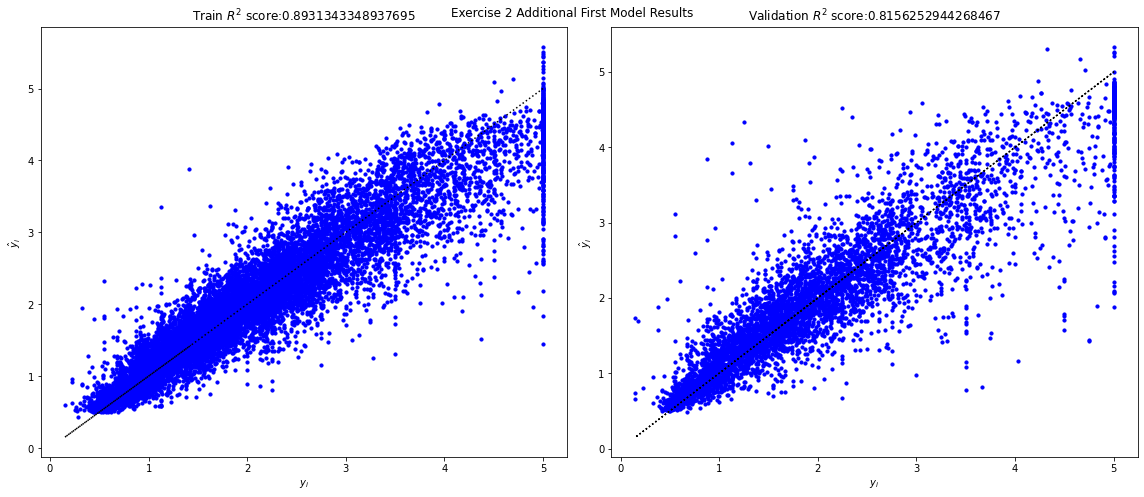

In [70]:
from torch.utils.data import DataLoader
from sklearn.metrics  import r2_score

#-- Entire dataset in one batch:
mTrainX, vTrainY = next(iter(DataLoader(oTrainSet, shuffle=False, batch_size=nTrain)))
mValX,   vValY   = next(iter(DataLoader(oValSet,   shuffle=False, batch_size=nTest )))

#-- Apply model to data:
with torch.no_grad():
    vHatTrainY = oModel(mTrainX.to(DEVICE)).detach().cpu()
    vHatValY   = oModel(mValX  .to(DEVICE)).detach().cpu()

_, ax = plt.subplots(1, 2, figsize=(16, 7))

ax[0].scatter   (vTrainY, vHatTrainY, s=10, c='b', edgecolor=None)
ax[1].scatter   (vValY,   vHatValY,   s=10, c='b', edgecolor=None)
ax[0].plot      (vTrainY, vTrainY, ':k')
ax[1].plot      (vValY,   vValY,   ':k')
ax[0].set_title ('Train $R^2$ score:'      f'{r2_score(vTrainY, vHatTrainY)}')
ax[1].set_title ('Validation $R^2$ score:' f'{r2_score(vValY,   vHatValY)}')
ax[0].set_xlabel('$y_i$')
ax[1].set_xlabel('$y_i$')
ax[0].set_ylabel('$\hat{y}_i$')
ax[1].set_ylabel('$\hat{y}_i$')

plt.tight_layout()
plt.suptitle('Exercise 2 Additional First Model Results')
plt.show        ()

### Second Model option

In [71]:
nEpochs = 100
Loss    = nn.MSELoss()            #-- Loss method used

oModel  = GetModel2().to(DEVICE)  #-- Transfer the new model to GPU
#oOptim = optim.AdamW             (oModel.parameters(), lr=5e-4, betas=(0.9, 0.99), weight_decay=2e-4)  #-- Implement AdamW optimization
oOptim  = optim.SGD               (oModel.parameters(), lr=0.01, momentum=0.9)   #-- Implement Stohastic Gradient Descent

lHistory = TrainRegressionModel(oModel, oTrainDL, oValDL, Loss, nEpochs, oOptim)  #-- train and validate the model

Epoch 000: | Train loss:  0.802 | Val loss:  0.499 | Train R2: +0.389 | Val R2: +0.620 | Epoch time: 0.674 | <-- Checkpoint!
Epoch 001: | Train loss:  0.486 | Val loss:  0.402 | Train R2: +0.631 | Val R2: +0.693 | Epoch time: 0.673 | <-- Checkpoint!
Epoch 002: | Train loss:  0.440 | Val loss:  0.381 | Train R2: +0.666 | Val R2: +0.709 | Epoch time: 0.646 | <-- Checkpoint!
Epoch 003: | Train loss:  0.430 | Val loss:  0.380 | Train R2: +0.674 | Val R2: +0.709 | Epoch time: 0.652 | <-- Checkpoint!
Epoch 004: | Train loss:  0.430 | Val loss:  0.353 | Train R2: +0.671 | Val R2: +0.730 | Epoch time: 0.649 | <-- Checkpoint!
Epoch 005: | Train loss:  0.390 | Val loss:  0.350 | Train R2: +0.704 | Val R2: +0.732 | Epoch time: 0.678 | <-- Checkpoint!
Epoch 006: | Train loss:  0.396 | Val loss:  0.339 | Train R2: +0.699 | Val R2: +0.740 | Epoch time: 0.651 | <-- Checkpoint!
Epoch 007: | Train loss:  0.371 | Val loss:  0.438 | Train R2: +0.718 | Val R2: +0.664 | Epoch time: 0.625 |
Epoch 008: | Tra

In [72]:
#-- It is posible to test a finite set of hyperparameters' values and to choose
#-- the optimum value which achieves the highest value for the validation R2_score.

vTrainLoss, vTrainR2, vValLoss, vValR2 = lHistory
print(f"The maximum validation R2_score achieved is {max(vValR2)}")

The maximum validation R2_score achieved is 0.8141436020830514


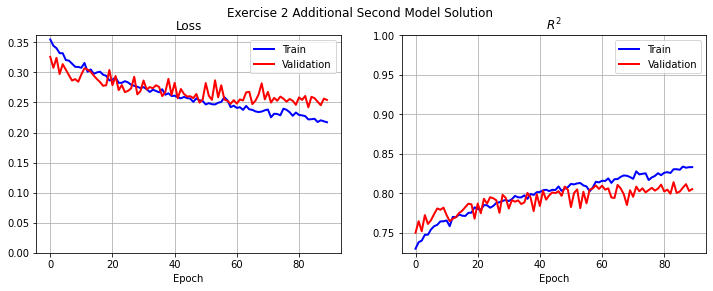

In [73]:
PlotHistory (lHistory)
plt.suptitle('Exercise 2 Additional Second Model Solution')
plt.show    ()

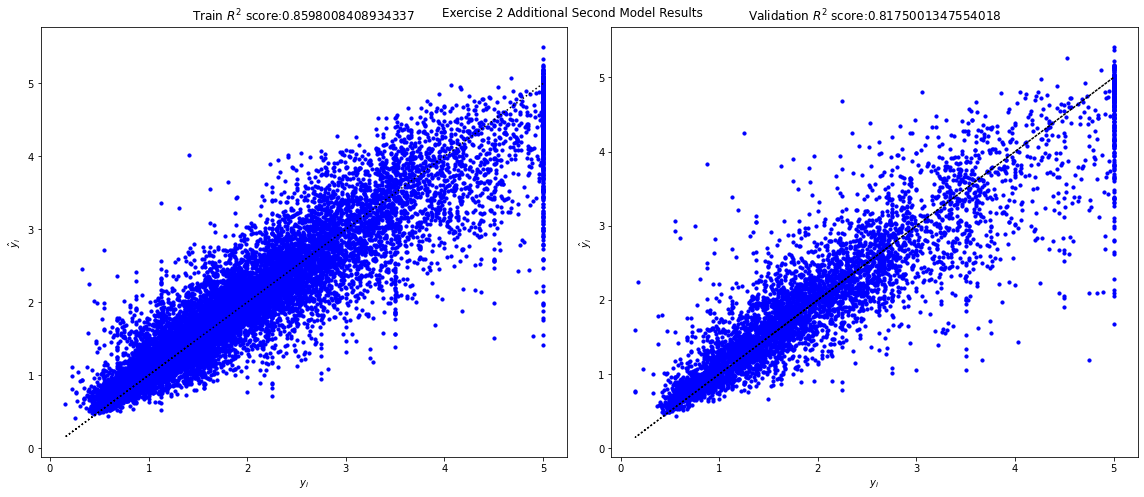

In [74]:
from torch.utils.data import DataLoader
from sklearn.metrics  import r2_score

#-- Entire dataset in one batch:
mTrainX, vTrainY = next(iter(DataLoader(oTrainSet, shuffle=False, batch_size=nTrain)))
mValX,   vValY   = next(iter(DataLoader(oValSet,   shuffle=False, batch_size=nTest )))

#-- Apply model to data:
with torch.no_grad():
    vHatTrainY = oModel(mTrainX.to(DEVICE)).detach().cpu()
    vHatValY   = oModel(mValX  .to(DEVICE)).detach().cpu()

_, ax = plt.subplots(1, 2, figsize=(16, 7))

ax[0].scatter   (vTrainY, vHatTrainY, s=10, c='b', edgecolor=None)
ax[1].scatter   (vValY,   vHatValY,   s=10, c='b', edgecolor=None)
ax[0].plot      (vTrainY, vTrainY, ':k')
ax[1].plot      (vValY,   vValY,   ':k')
ax[0].set_title ('Train $R^2$ score:'      f'{r2_score(vTrainY, vHatTrainY)}')
ax[1].set_title ('Validation $R^2$ score:' f'{r2_score(vValY,   vHatValY)}')
ax[0].set_xlabel('$y_i$')
ax[1].set_xlabel('$y_i$')
ax[0].set_ylabel('$\hat{y}_i$')
ax[1].set_ylabel('$\hat{y}_i$')

plt.tight_layout()
plt.suptitle('Exercise 2 Additional Second Model Results')
plt.show        ()

In [75]:
# def GetModel2():
#     oModel = nn.Sequential(
#         nn.Identity(), #-- does nothing
#         nn.Flatten (),
        
#         nn.Linear(3*32*32, 500), nn.Dropout(0.1), nn.ReLU(),
#         nn.Linear(500,     250), nn.Dropout(0.1), nn.ReLU(),
#         nn.Linear(250,      10)
#     )
#     return oModel

# nEpochs = 20
# Loss    = nn.CrossEntropyLoss()

# oModel   = GetModel2              ().to(DEVICE)
# oOptim   = optim.AdamW            (oModel.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=2e-4)
# lHistory = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim);